In [62]:
import sys
import os


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [63]:
from src.transport_truck import simulate_truck_allocation_pandas
from src.deplyment import accurate_deployment
from src.rating import build_rating
from src.prod_cut import apply_production_cut

In [64]:
import polars as pl 
import numpy as np
from datetime import timedelta, datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

pal_size_df = pl.read_csv("Symulation data/pal_size_df.csv")
demand_outlook = pl.read_csv("Symulation data/demand_outlook.csv")
deployment_outlook = pl.read_csv("Data/Deployment_Before.csv")
df_tt = pl.read_csv("Symulation data/lane_rules.csv")
prod_master = pl.read_csv("Symulation data/prod_master.csv")
prod_plan = pl.read_csv("Data/Prod_Plan_Before.csv")
price_df = pl.read_csv("Symulation data/price.csv")

demand_outlook = demand_outlook.with_columns([
    (pl.col("date").str.to_date()).alias("date")
])

date_map_df = (demand_outlook.select(["day","date"]).unique())

item_prices = price_df.group_by("item_id").agg([
    pl.mean("sell_price").round(2).alias("avg_sell_price")
])


In [65]:
DF_DC_delivs = (
    deployment_outlook.join(df_tt, how="left", on=["plant_id", "store_id"])
    .join(date_map_df, how="left", on="day")
    .with_columns([
    ((pl.col("date")) + pl.duration(days=pl.col("transit_time_days"))).alias("delivery_date")])
    .select(["plant_id", "store_id", "item_id", "qty_sent","delivery_date"])
    .rename({"plant_id": "delivery_plant_id"})
)

projection_df = (
     demand_outlook.join(DF_DC_delivs, how="left", left_on=["store_id","item_id","date"], right_on=["store_id", "item_id","delivery_date"])
     .select(["store_id", "item_id", "plant_id", "cat_id", "day", "date", "safety_stock_static", "SOG_initial","forecast_sales", "qty_sent"])
     .with_columns([
         pl.col("qty_sent").fill_null(0)
     ])
)

In [66]:
projection_df = projection_df.with_columns([
    ((pl.col("SOG_initial")) - pl.col("forecast_sales") + pl.col("qty_sent")).cum_sum()
     .over(["item_id", "store_id"])
     .alias("inv_projection")
     ])
projection_df = projection_df.with_columns([
    pl.when(pl.col("inv_projection") < pl.col("safety_stock_static"))
    .then((pl.col("safety_stock_static") - pl.col("inv_projection"))*(-1))
    .otherwise(0)
    .alias("SS_risk_projection")
])

projection_df = projection_df.with_columns([
    pl.when(pl.col("inv_projection") < 0)
    .then(pl.col("inv_projection"))
    .otherwise(0)
    .alias("OOS_risk_projection")
])

projection_df = projection_df.with_columns([
    pl.col("SS_risk_projection").min().over(["item_id", "store_id"]).alias("SS_risk_peak")])

projection_df = projection_df.with_columns([
    pl.col("OOS_risk_projection").min().over(["item_id", "store_id"]).alias("OOS_risk_peak")])

projection_df.write_csv("Data/Risk_Projection_Before.csv")

In [67]:
rate_df = (
    projection_df.join(prod_plan, how="left", on=["plant_id", "item_id", "day"])
    .join(prod_master, how="left", on=["plant_id", "item_id"])
    .join(price_df, how="left", on=["store_id", "item_id"])
    .select(["store_id", "item_id","plant_id","day", "forecast_sales",
             "safety_stock_static", "inv_projection", "SS_risk_projection","OOS_risk_projection",
             "OOS_risk_peak", "SS_risk_peak", "cycle_days", "MOQ_units", "production_quantity",
             "total_daily_requirement", "production_stock", "sell_price"
            ])
             
)

In [68]:
rating_df = build_rating(rate_df)

In [69]:
# 1️Aggregate store-level metrics to plant-level
plant_risk_df = (
    rate_df.group_by(["plant_id", "item_id", "day"])
    .agg([
        pl.sum("forecast_sales").alias("total_daily_requirement"),
        pl.sum("SS_risk_peak").alias("SS_risk_peak"),
        pl.sum("OOS_risk_peak").alias("OOS_risk_peak"),
    ])
)

# 2️Aggregate price_df to plant-level (average across stores)
plant_price_df = (
    price_df.join(rate_df.select(["store_id", "plant_id"]).unique(), on="store_id", how="left")
    .group_by(["plant_id", "item_id"])
    .agg([
        pl.col("sell_price").mean().alias("sell_price")
    ])
)

# 3️Join production plan with aggregated risks
plant_stageB_df = (
    prod_plan.join(
        plant_risk_df,
        on=["plant_id", "item_id", "day"],
        how="left"
    ).join(
        plant_price_df,
        on=["plant_id", "item_id"],
        how="left"
    )
)

plant_stageB_df = (
    plant_stageB_df.join(
        rating_df,
        on=["plant_id", "item_id"],
        how="left"
    )
)

In [70]:
plant_stageB_df_pd = plant_stageB_df.to_pandas()

updated_plan_pd = apply_production_cut(production_plan_df = plant_stageB_df_pd,
                                       cut_type="%", ## change here to "units" or "%" for flat cut
                                       cut_value=10, # value of a cut
                                       horizon_days=list(range(1,31)) #date range used for cut
                                       # plant_filter= "PLANT_CA" #plants that we will cut from if plant full scope
                                      )

updated_plan_pl = pl.from_pandas(updated_plan_pd)
updated_plan_pd.to_csv("Data/Prod_Plan_After.csv")

✅ Applied cut: 4064.20 / Target: 4066.00 (100.0%) for plants: ALL


In [71]:
updated_plan_pl = pl.from_pandas(updated_plan_pd)

pudated_plan_pl = updated_plan_pl.filter(pl.col("day") <= 30)

updated_deplyment = accurate_deployment(updated_plan_pl, demand_outlook)

In [72]:
# --- Step 1: build pallets summary ---
updated_deployment_with_pallets = updated_deplyment.join(
    pal_size_df, on="plant_id", how="left"
)

updated_deployment_with_pallets = updated_deployment_with_pallets.with_columns([
    (pl.col("quantity") / pl.col("pallet_size")).alias("pallet_exact")
])

updated_daily_pallet_summary = (
    updated_deployment_with_pallets
    .group_by(["day", "plant_id", "item_id", "store_id", "priority", "pallet_size"])
    .agg([
        pl.col("pallet_exact").sum().alias("store_pallet_total"),
        pl.col("quantity").sum().alias("deployment_qty")
    ])
    .sort(["day", "plant_id", "store_id", "item_id", "priority"])
)

# --- move from Polars → Pandas ---
updated_daily_pallet_summary_pd = updated_daily_pallet_summary.to_pandas() 

In [73]:
updated_deplyment_palletized = simulate_truck_allocation_pandas(updated_daily_pallet_summary_pd, truck_capacity=34.0)

In [74]:
updated_deplyment_palletized.to_csv("Data/Deployment_After.csv")

In [75]:
updated_deplyment_palletized_pl = pl.from_pandas(updated_deplyment_palletized)

In [76]:
updated_deplyment_palletized_pl = (
    updated_deplyment_palletized_pl.group_by(["day", "plant_id", "store_id", "item_id", "pallet_size"])
    .agg([pl.col("qty_sent").sum().alias("qty_sent"),
          pl.col("pallets_sent").sum().alias("pallets_sent")])
)

In [77]:
Post_cut_DF_DC_delivs = (
    updated_deplyment_palletized_pl.join(df_tt, how="left", on=["plant_id", "store_id"])
    .join(date_map_df, how="left", on="day")
    .with_columns([
    ((pl.col("date")) + pl.duration(days=pl.col("transit_time_days"))).alias("delivery_date")])
    .select(["plant_id", "store_id", "item_id", "qty_sent","delivery_date"])
    .rename({"plant_id": "delivery_plant_id"})
)

demand_outlook = demand_outlook.filter(pl.col("day") <= 30)

post_cut_projection_df = (
     demand_outlook.join(Post_cut_DF_DC_delivs, how="left", left_on=["store_id","item_id","date"], right_on=["store_id", "item_id","delivery_date"])
     .select(["store_id", "item_id", "plant_id", "cat_id", "day", "date", "safety_stock_static", "SOG_initial","forecast_sales", "qty_sent"])
     .with_columns([
         pl.col("qty_sent").fill_null(0)
     ])
)

post_cut_projection_df = post_cut_projection_df.with_columns([
    ((pl.col("SOG_initial")) - pl.col("forecast_sales") + pl.col("qty_sent")).cum_sum()
     .over(["item_id", "store_id"])
     .alias("inv_projection")
     ])
post_cut_projection_df = post_cut_projection_df.with_columns([
    pl.when(pl.col("inv_projection") < pl.col("safety_stock_static"))
    .then((pl.col("safety_stock_static") - pl.col("inv_projection"))*(-1))
    .otherwise(0)
    .alias("SS_risk_projection")
])

post_cut_projection_df = post_cut_projection_df.with_columns([
    pl.when(pl.col("inv_projection") < 0)
    .then(pl.col("inv_projection"))
    .otherwise(0)
    .alias("OOS_risk_projection")
])

post_cut_projection_df = post_cut_projection_df.with_columns([
    pl.col("SS_risk_projection").min().over(["item_id", "store_id"]).alias("SS_risk_peak")])

post_cut_projection_df = post_cut_projection_df.with_columns([
    pl.col("OOS_risk_projection").min().over(["item_id", "store_id"]).alias("OOS_risk_peak")])

post_cut_projection_df.write_csv("Data/Risk_Projection_After.csv")

In [78]:
before = projection_df.with_columns(pl.lit("Before Cut").alias("Version"))
after = post_cut_projection_df.with_columns(pl.lit("After Cut").alias("Version"))

cols = ["plant_id", "store_id", "item_id", "day", "date", "forecast_sales", "safety_stock_static", "SS_risk_projection", "OOS_risk_projection", "SS_risk_peak", "OOS_risk_peak", "Version"]
combined = pl.concat([before.select(cols), after.select(cols)])

before_prod = prod_plan.with_columns(pl.lit("Before Cut").alias("Version"))
after_prod = updated_plan_pl.with_columns(pl.lit("After Cut").alias("Version"))

prod_cols = ["plant_id", "item_id", "day", "date","starting_inventory_plant", "cycle_days", "MOQ_units", "production_quantity", "Version"]
prod_combined = pl.concat([before_prod.select(prod_cols), after_prod.select(prod_cols)])



before_deplo = deployment_outlook.with_columns(pl.lit("Before Cut").alias("Version"))
after_deplo = updated_deplyment_palletized_pl.with_columns(pl.lit("After Cut").alias("Version"))

deplo_cols = ["plant_id", "store_id", "item_id", "day", "qty_sent", "pallets_sent", "Version"]
deplo_combined = pl.concat([before_deplo.select(deplo_cols), after_deplo.select(deplo_cols)])

deplo_combined = deplo_combined.with_columns([
    (pl.col("pallets_sent")/ 34).alias("trucks_sent")
])

# Join prices with all datasets
combined = (combined.join(item_prices, on=["item_id"], how="left")
            .filter(pl.col("day") <=30)
           )
prod_combined = (prod_combined.join(item_prices, on=["item_id"], how="left")
                 .filter(pl.col("day") <=30)
                )
deplo_combined = (deplo_combined.join(item_prices, on=["item_id"], how="left")
                  .filter(pl.col("day") <=30))

# Calculate dollar-valued metrics
combined = combined.with_columns([
    (pl.col("SS_risk_projection") * pl.col("avg_sell_price")).alias("ss_risk_dollar"),
    (pl.col("OOS_risk_projection") * pl.col("avg_sell_price")).alias("oos_risk_dollar"),
    (pl.col("forecast_sales").cum_sum().over(["item_id", "store_id", "Version"]).alias("cum_forecast"))
])

prod_combined = prod_combined.with_columns([
    (pl.col("production_quantity") * pl.col("avg_sell_price")).alias("production_value")
])

deplo_combined = deplo_combined.with_columns([
    (pl.col("qty_sent") * pl.col("avg_sell_price")).alias("deployment_value")
])


In [79]:
combined_pd = combined.to_pandas()
prod_combined_pd = prod_combined.to_pandas()
eplo_combined_pd = deplo_combined.to_pandas()

C:\Users\Przemek\AppData\Local\Temp\ipykernel_12048\490101459.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Przemek\AppData\Local\Temp\ipykernel_12048\490101459.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig("risk_projection_evolution.png", dpi=300, bbox_inches='tight')
C:\Users\Przemek\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


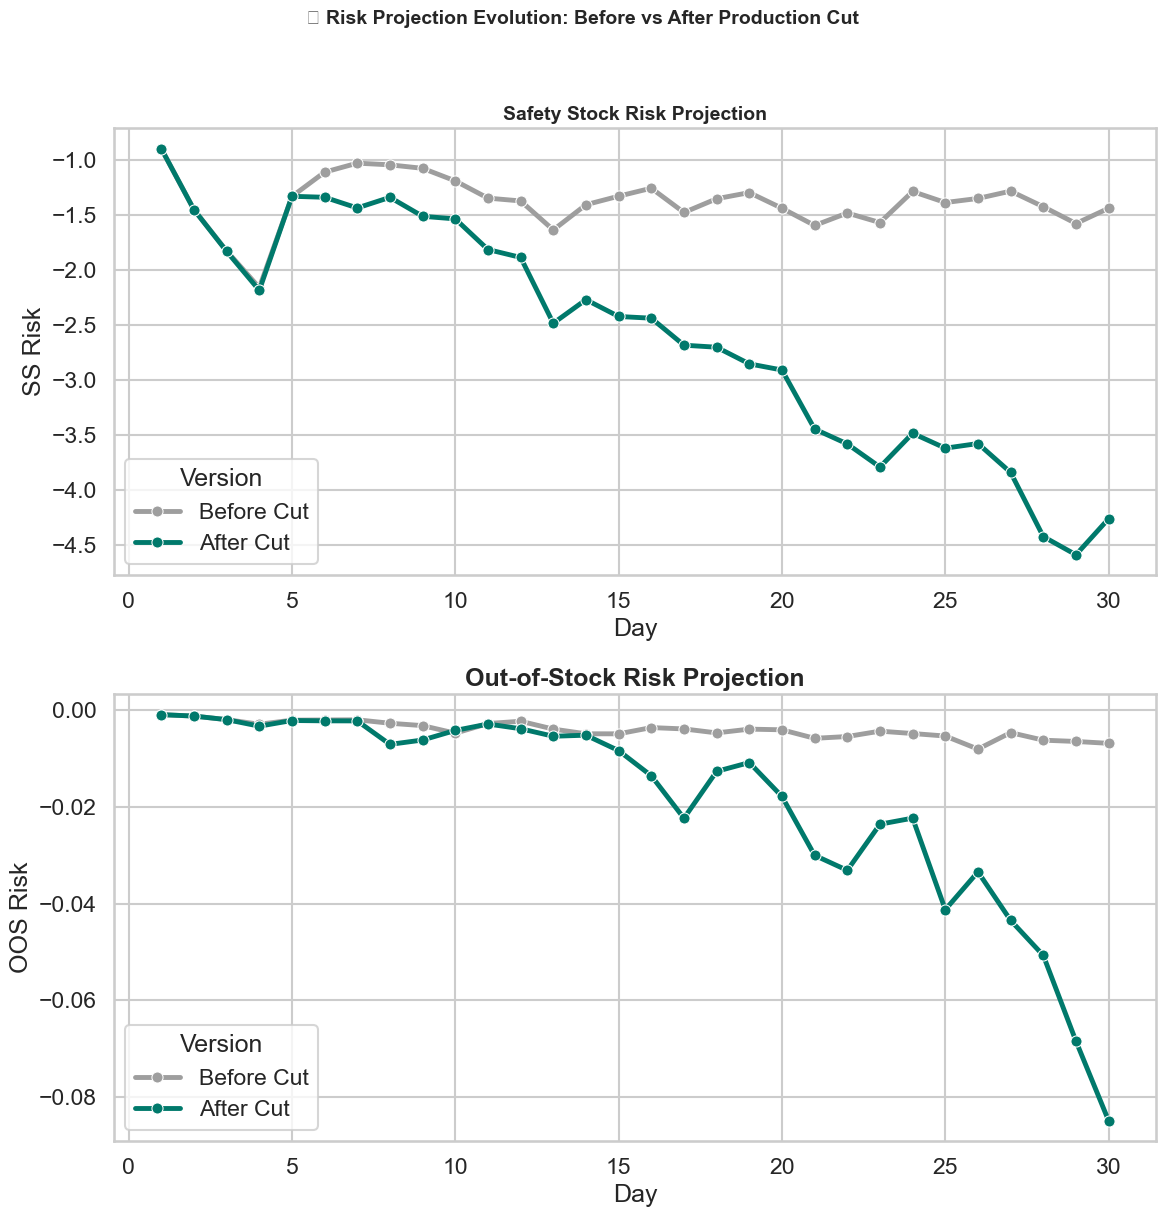

In [80]:
sns.set_theme(style="whitegrid", context="talk")

# Create the 1x1 grid for projection values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

colors = {"Before Cut": "#9E9E9E", "After Cut": "#00796B"}


# SS Risk Projection - simplified with markers
sns.lineplot(
    data=combined_pd,
    x="day", 
    y="SS_risk_projection",
    hue="Version",
    ax=ax1,
    linewidth=3.5,
    errorbar=None,
    marker='o',  # Simple marker addition
    markersize=8,
    palette=colors
)

ax1.set_title("Safety Stock Risk Projection", weight='bold', fontsize=14)
ax1.set_ylabel("SS Risk")
ax1.set_xlabel("Day")

# OOS Risk Projection - simplified with markers
sns.lineplot(
    data=combined_pd,
    x="day", 
    y="OOS_risk_projection",
    hue="Version",
    ax=ax2,
    linewidth=3.5,
    errorbar=None,
    marker='o',  # Simple marker addition
    markersize=8,
    palette=colors
)

ax2.set_title("Out-of-Stock Risk Projection", weight='bold', fontsize=18)
ax2.set_ylabel("OOS Risk")
ax2.set_xlabel("Day")

plt.suptitle("📊 Risk Projection Evolution: Before vs After Production Cut", 
             fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig("risk_projection_evolution.png", dpi=300, bbox_inches='tight')
plt.show()

In [81]:
day_30_risk = combined.filter(pl.col("day") == 30)

peak_risk_summary = day_30_risk.group_by("Version").agg([
    pl.sum("SS_risk_peak").round(4).alias("📊 SS Risk Score"),
    pl.sum("OOS_risk_peak").round(4).alias("⚠️  OOS Risk Score"),
    (pl.sum("SS_risk_peak") * pl.mean("avg_sell_price")).round(2).alias("💸 SS Risk ($)"),
    pl.sum("safety_stock_static").round(0).alias("🛡️  Total SS Units"),
    (pl.sum("SS_risk_peak") / pl.sum("safety_stock_static") * 100).round(2).alias("📦 SS Consumption (%)"),
    (pl.sum("OOS_risk_peak") * pl.mean("avg_sell_price")).round(2).alias("💔 OOS Risk ($)"),
    pl.sum("cum_forecast").round(0).alias("📈 30-day Forecast")
])

print("\n🎯 DAY 30 RISK DASHBOARD")
print("-" * 25)
print(peak_risk_summary)

# --- Simple summary line ---
risk_totals = (
    peak_risk_summary
    .select(["Version", "💸 SS Risk ($)", "💔 OOS Risk ($)"])
    .to_dict(as_series=False)
)
before_ss, after_ss = risk_totals["💸 SS Risk ($)"]
before_oos, after_oos = risk_totals["💔 OOS Risk ($)"]
print(f"📉 SS risk changed by {before_ss - after_ss:-.2f} $ | OOS risk changed by {before_oos - after_oos:-.2f} $")

cfr_summary = day_30_risk.group_by("Version").agg([
    pl.sum("cum_forecast").alias("📦 Total Demand"),
    pl.sum("OOS_risk_peak").alias("💔 Unserved Volume"),
    (100 * (1 - (pl.sum("OOS_risk_peak").abs() / pl.sum("cum_forecast")))).round(2).alias("🤝 CFR_%"),
])

print("\n🤝 CUSTOMER FILL RATE SUMMARY")
print("-" * 25)
print(cfr_summary)


production_summary = prod_combined.group_by(["plant_id", "Version"]).agg([
    pl.sum("production_quantity").alias("🏭 Total Units"),
    pl.sum("production_value").round(0).alias("💰 Value (USD)"),
    # pl.count().alias("📅 Production Days"),
    pl.mean("avg_sell_price").round(2).alias("🏷️  Avg Price")
]).sort(["plant_id", "Version"])

print("\n🔥 PRODUCTION OVERVIEW")
print("-" * 25)
print(production_summary)

# --- Simple summary line ---
prod_total = (
    production_summary
    .group_by("Version")
    .agg(pl.sum("💰 Value (USD)").alias("total_val"))
    .sort("Version")
    .to_dict(as_series=False)
)
before_prod, after_prod = prod_total["total_val"]
print(f"🏭 Production value reduced by ${before_prod - after_prod:,.0f} total")

deployment_summary = deplo_combined.group_by(["plant_id", "Version"]).agg([
    pl.sum("qty_sent").alias("📦 Units Shipped"),
    pl.sum("deployment_value").round(0).alias("💵 Value Shipped (USD)"),
    pl.sum("trucks_sent").round(0).alias("🚛 Trucks Sent"),
    pl.mean("avg_sell_price").round(2).alias("🏷️  Avg Sell Price")
]).sort(["plant_id", "Version"])

print("\n📤 DEPLOYMENT SUMMARY")
print("-" * 25)
print(deployment_summary)

# --- Simple summary line ---
deplo_total = (
    deployment_summary
    .group_by("Version")
    .agg(pl.sum("🚛 Trucks Sent").alias("trucks"))
    .sort("Version")
    .to_dict(as_series=False)
)
before_truck, after_truck = deplo_total["trucks"]
print(f"🚚 Shipments optimized by {before_truck - after_truck:+.0f} trucks overall")


🎯 DAY 30 RISK DASHBOARD
-------------------------
shape: (2, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Version    ┆ 📊 SS Risk ┆ ⚠️  OOS    ┆ 💸 SS     ┆ 🛡️  Total ┆ 📦 SS Con ┆ 💔 OOS    ┆ 📈 30-day │
│ ---        ┆ Score      ┆ Risk Score ┆ Risk ($)  ┆ SS Units  ┆ sumption  ┆ Risk ($)  ┆ Forecast  │
│ str        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ (%)       ┆ ---       ┆ ---       │
│            ┆ f64        ┆ f64        ┆ f64       ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆           ┆           ┆ f64       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ After Cut  ┆ -6650.6378 ┆ -199.9637  ┆ -28932.51 ┆ 9467.0    ┆ -70.25    ┆ -869.91   ┆ 43189.0   │
│ Before Cut ┆ -4811.4601 ┆ -59.7316   ┆ -20931.47 ┆ 9467.0    ┆ -50.83    ┆ -259.85   ┆ 43189.0   │
└────────────┴────────────┴────